In [1]:
import os
import shutil  # Ensure shutil is imported
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn, optim
from ultralytics import YOLO
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from PIL import Image

# Valid image extensions
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif')

def is_valid_image(file_name):
    return file_name.lower().endswith(valid_extensions)

def is_corrupt(file_path):
    try:
        img = Image.open(file_path)
        img.verify()
        return False
    except Exception:
        return True

def organize_dataset(dataset_path, output_path="organized_dataset"):
    """
    Organize images into a dataset folder with train, val, and test splits.
    """
    subfolders = os.listdir(dataset_path)
    for subfolder in subfolders:
        subfolder_path = os.path.join(dataset_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        images = os.listdir(subfolder_path)
        images = [img for img in images if is_valid_image(img)]  # Only valid images
        if not images:
            print(f"No valid images in folder: {subfolder_path}")
            continue
        train, temp = train_test_split(images, test_size=0.3, random_state=42)
        val, test = train_test_split(temp, test_size=0.5, random_state=42)

        for split, split_name in zip([train, val, test], ['train', 'val', 'test']):
            split_folder = os.path.join(output_path, split_name, subfolder.replace(" ", "_"))
            os.makedirs(split_folder, exist_ok=True)
            for img in split:
                src = os.path.join(subfolder_path, img)
                dest = os.path.join(split_folder, img)
                if is_corrupt(src):
                    print(f"Skipping {src}: Corrupted file.")
                    continue
                try:
                    shutil.copy(src, dest)
                    print(f"Copied {src} to {dest}")
                except Exception as e:
                    print(f"Error copying {src} to {dest}: {e}")

def prepare_dataset(data_dir):
    """
    Prepare the dataset with necessary transformations.
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    datasets_dict = {}
    for phase in ['train', 'val', 'test']:
        phase_dir = os.path.join(data_dir, phase)
        if not os.path.exists(phase_dir) or not os.listdir(phase_dir):
            print(f"Warning: No images found in {phase_dir}")
            continue
        datasets_dict[phase] = datasets.ImageFolder(phase_dir, transform=transform)
    if 'train' not in datasets_dict:
        raise FileNotFoundError("No training data found. Ensure that the train folder contains valid images.")
    dataloaders = {
        x: DataLoader(datasets_dict[x], batch_size=16, shuffle=True, num_workers=4)
        for x in datasets_dict.keys()
    }
    return dataloaders, len(datasets_dict['train'].classes)

def train_model(dataloaders, num_classes, epochs=20):
    """
    Fine-tune YOLOv8 classification model.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = YOLO("yolo11n-cls.pt")  # Load YOLOv8 pre-trained model

    # Replace the classification head
    num_features = model.model.model[-1].linear.in_features  # Access the input features of the linear layer
    model.model.model[-1].linear = nn.Linear(num_features, num_classes)  # Replace the linear layer

    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.model.parameters(), lr=0.001)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.model.train()
            else:
                model.model.eval()

            running_loss = 0.0
            correct = 0

            for inputs, labels in tqdm(dataloaders.get(phase, [])):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model.model(inputs)
                    if isinstance(outputs, tuple):  # Handle tuple outputs
                        outputs = outputs[0]  # Extract the classification logits
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = correct.double() / len(dataloaders[phase].dataset)
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    return model

def save_model(model, save_path="yolov11n_car_model.pt"):
    """
    Save the trained model.
    """
    torch.save(model.model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

if __name__ == "__main__":
    # Paths
    dataset_path = "C:\\Users\\ENL-LPT022\\Downloads\\NLV"
    data_dir = "C:\\Users\\ENL-LPT022\\Downloads\\NLV_organized"

    # Step 1: Organize Dataset
    organize_dataset(dataset_path, output_path=data_dir)

    # Step 2: Prepare Dataset
    dataloaders, num_classes = prepare_dataset(data_dir)

    # Step 3: Train Model
    trained_model = train_model(dataloaders, num_classes)

    # Step 4: Save Model
    save_model(trained_model)


Copied C:\Users\ENL-LPT022\Downloads\NLV\Aston Martin Vantage\aston martin vantage (3).jpeg to C:\Users\ENL-LPT022\Downloads\NLV_organized\train\Aston_Martin_Vantage\aston martin vantage (3).jpeg
Copied C:\Users\ENL-LPT022\Downloads\NLV\Aston Martin Vantage\aston martin vantage (5).jpeg to C:\Users\ENL-LPT022\Downloads\NLV_organized\train\Aston_Martin_Vantage\aston martin vantage (5).jpeg
Copied C:\Users\ENL-LPT022\Downloads\NLV\Aston Martin Vantage\aston martin vantage (4).jpeg to C:\Users\ENL-LPT022\Downloads\NLV_organized\train\Aston_Martin_Vantage\aston martin vantage (4).jpeg
Copied C:\Users\ENL-LPT022\Downloads\NLV\Aston Martin Vantage\aston martin vantage (7).jpeg to C:\Users\ENL-LPT022\Downloads\NLV_organized\train\Aston_Martin_Vantage\aston martin vantage (7).jpeg
Copied C:\Users\ENL-LPT022\Downloads\NLV\Aston Martin Vantage\aston martin vantage (6).jpeg to C:\Users\ENL-LPT022\Downloads\NLV_organized\val\Aston_Martin_Vantage\aston martin vantage (6).jpeg
Copied C:\Users\ENL-LP

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:33<00:00,  1.19s/it]


train Loss: 3.1957 Acc: 0.2909


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:25<00:00,  1.39s/it]


val Loss: 3.7814 Acc: 0.5145
Epoch 2/20


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:27<00:00,  1.11s/it]


train Loss: 1.4830 Acc: 0.6884


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:24<00:00,  1.35s/it]


val Loss: 3.6134 Acc: 0.6558
Epoch 3/20


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:27<00:00,  1.11s/it]


train Loss: 0.9868 Acc: 0.8052


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:24<00:00,  1.37s/it]


val Loss: 3.5163 Acc: 0.7101
Epoch 4/20


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:25<00:00,  1.09s/it]


train Loss: 0.6885 Acc: 0.8657


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:24<00:00,  1.34s/it]


val Loss: 3.4732 Acc: 0.7283
Epoch 5/20


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:29<00:00,  1.13s/it]


train Loss: 0.5222 Acc: 0.8998


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:24<00:00,  1.36s/it]


val Loss: 3.4370 Acc: 0.7210
Epoch 6/20


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:28<00:00,  1.12s/it]


train Loss: 0.3990 Acc: 0.9324


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:27<00:00,  1.53s/it]


val Loss: 3.4222 Acc: 0.7355
Epoch 7/20


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:27<00:00,  1.10s/it]


train Loss: 0.3268 Acc: 0.9523


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:24<00:00,  1.37s/it]


val Loss: 3.3989 Acc: 0.7283
Epoch 8/20


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:27<00:00,  1.11s/it]


train Loss: 0.2632 Acc: 0.9650


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:24<00:00,  1.36s/it]


val Loss: 3.3819 Acc: 0.7717
Epoch 9/20


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:28<00:00,  1.12s/it]


train Loss: 0.1943 Acc: 0.9865


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:24<00:00,  1.36s/it]


val Loss: 3.3760 Acc: 0.7536
Epoch 10/20


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:28<00:00,  1.12s/it]


train Loss: 0.1644 Acc: 0.9865


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:24<00:00,  1.36s/it]


val Loss: 3.3777 Acc: 0.7428
Epoch 11/20


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:28<00:00,  1.12s/it]


train Loss: 0.1482 Acc: 0.9865


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:25<00:00,  1.40s/it]


val Loss: 3.3558 Acc: 0.7754
Epoch 12/20


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:28<00:00,  1.12s/it]


train Loss: 0.1297 Acc: 0.9921


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:24<00:00,  1.38s/it]


val Loss: 3.3451 Acc: 0.7862
Epoch 13/20


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:28<00:00,  1.12s/it]


train Loss: 0.1198 Acc: 0.9905


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:24<00:00,  1.35s/it]


val Loss: 3.3418 Acc: 0.7826
Epoch 14/20


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:28<00:00,  1.12s/it]


train Loss: 0.0983 Acc: 0.9928


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:24<00:00,  1.37s/it]


val Loss: 3.3332 Acc: 0.7862
Epoch 15/20


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:28<00:00,  1.13s/it]


train Loss: 0.0937 Acc: 0.9913


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:24<00:00,  1.36s/it]


val Loss: 3.3337 Acc: 0.7826
Epoch 16/20


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:28<00:00,  1.12s/it]


train Loss: 0.0911 Acc: 0.9921


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:24<00:00,  1.36s/it]


val Loss: 3.3248 Acc: 0.7935
Epoch 17/20


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:28<00:00,  1.12s/it]


train Loss: 0.0686 Acc: 0.9960


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:24<00:00,  1.37s/it]


val Loss: 3.3231 Acc: 0.7790
Epoch 18/20


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:28<00:00,  1.12s/it]


train Loss: 0.0635 Acc: 0.9976


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:24<00:00,  1.37s/it]


val Loss: 3.3227 Acc: 0.7826
Epoch 19/20


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:28<00:00,  1.12s/it]


train Loss: 0.0587 Acc: 0.9968


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:24<00:00,  1.37s/it]


val Loss: 3.3256 Acc: 0.7826
Epoch 20/20


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:28<00:00,  1.12s/it]


train Loss: 0.0534 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:24<00:00,  1.36s/it]

val Loss: 3.3208 Acc: 0.7790
Model saved to yolov11n_car_model.pt


In [5]:
from ultralytics import YOLO
from torch import nn
import torch

# Load YOLO model
model = YOLO("yolo11n-cls.pt")

# Replace classification head to match the trained checkpoint
num_classes = 56  # Update this to match the number of classes in your training dataset
num_features = model.model.model[-1].linear.in_features
model.model.model[-1].linear = nn.Linear(num_features, num_classes)

# Load the trained weights
model_path = "yolov11n_car_model.pt"
model.model.load_state_dict(torch.load(model_path))

model.eval()  # Set to evaluation mode
print("Model loaded successfully!")


Model loaded successfully!


In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    return transform(img).unsqueeze(0)  # Add batch dimension


In [31]:
import os
from ultralytics import YOLO
from torch import nn
import torch

def classify_image(model_path, class_names, image_path):
    """
    Classify an image using a YOLOv8 model.

    Parameters:
        model_path (str): Path to the trained YOLOv8 model.
        class_names (list): List of class names corresponding to the model.
        image_path (str): Path to the image to classify.

    Returns:
        str: Predicted class name and confidence score.
    """
    # Check if the image path exists
    if not os.path.exists(image_path):
        raise ValueError(f"Invalid image file: {image_path}")

    # Load the trained YOLOv8 model
    model = YOLO(model_path)

    # Perform inference
    results = model.predict(source=image_path, device='cpu')

    # Extract predictions
    if len(results) == 0 or not hasattr(results[0], 'probs'):
        raise ValueError("No valid predictions made by the model.")

    prediction = results[0]
    predicted_class_index = prediction.probs.top1  # Index of highest probability
    confidence = prediction.probs.top1conf  # Confidence score

    # Validate class index
    if not (0 <= predicted_class_index < len(class_names)):
        raise ValueError(f"Predicted class index {predicted_class_index} is out of range.")

    return f"Predicted: {class_names[predicted_class_index]} (Confidence: {confidence:.2f})"

if __name__ == "__main__":
    # Define paths
    model_path = "yolov8n_car_model_complete.pt"  # Correctly saved YOLO model path
    image_path = r"C:\\Users\\ENL-LPT022\\Downloads\\TC.jpeg"  # Replace with your test image path

    # Class names
    class_names = [
        "Aston Martin Vantage", "Audi Q7", "Audi Q8", "BMW 5 Series", "BMW M4", "BMW M5",
        "BYD eMax 7", "BYD Seal", "Citroen Aircross", "Citroen Basalt", "Ferrari Purosangue SUV",
        "Force Motors Gurkha", "Honda Amaze", "Hyundai Alcazar", "Hyundai Creta", "Hyundai Creta N Line",
        "Isuzu V-Cross", "Jeep Wrangler", "Kia Carens", "Kia Carnival", "Kia EV9 Images", "Kia Seltos",
        "Kia Sonet", "Mahinda Be6", "Mahindra Thar Roxx", "Mahindra Xev9", "Mahindra XUV 3XO", "Maruthi Dzire",
        "Maruti Suzuki", "McLaren 750S", "Mercedes-Benz AMG C 63 S E", "Mercedes-Benz AMG G-Class",
        "Mercedes-Benz AMG GLC43", "Mercedes-Benz AMG GLE Coupe", "Mercedes-Benz E", "Mercedes-Benz EQA",
        "Mercedes-Benz EQS SUV", "Mercedes-Benz GLA", "Mercedes-Benz GLC", "Mercedes-Benz GLS",
        "Mercedes-Benz Maybach EQS SUV", "Mercedes-Benz Maybach GLS", "MG Windsor EV", "MINI Cooper",
        "MINI Countryman Electric", "Nissan Magnite", "Nissan X-Trail", "Skoda Kushaq", "Skoda Slavia",
        "Skoda Superb", "Skoda Kylash", "Tata Curvv", "Tata Curvv EV", "Tata Punch EV", "Toyota Urban Cruiser Taisor",
        "Volvo EX40"
    ]

    # Ensure the model is saved correctly
    try:
        # Load YOLO model and update classification head
        temp_model = YOLO("yolo11n-cls.pt")
        num_classes = 56
        num_features = temp_model.model.model[-1].linear.in_features
        temp_model.model.model[-1].linear = nn.Linear(num_features, num_classes)
        temp_model.model.load_state_dict(torch.load("yolov11n_car_model.pt"))
        temp_model.save(model_path)  # Save the model properly
        print("Model saved correctly.")
    except Exception as e:
        print(f"Error saving model: {e}")

    # Run classification
    try:
        result = classify_image(model_path, class_names, image_path)
        print(result)
    except Exception as e:
        print(f"Error: {e}")


Model saved correctly.

image 1/1 C:\Users\ENL-LPT022\Downloads\TC.jpeg: 224x224 triceratops 0.84, great_white_shark 0.10, thunder_snake 0.03, bullfrog 0.01, American_alligator 0.01, 46.0ms
Speed: 25.0ms preprocess, 46.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
Predicted: Tata Curvv (Confidence: 0.84)


Model saved correctly.

image 1/1 C:\Users\ENL-LPT022\Downloads\TC.jpeg: 224x224 triceratops 0.84, great_white_shark 0.09, thunder_snake 0.03, bullfrog 0.01, American_alligator 0.01, 35.0ms
Speed: 26.0ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
Image: C:\\Users\\ENL-LPT022\\Downloads\\TC.jpeg, Predicted: Tata Curvv (Confidence: 0.84)

image 1/1 C:\Users\ENL-LPT022\Downloads\NXT.jpeg: 224x224 robin 0.44, goldfish 0.09, chickadee 0.05, green_snake 0.05, cock 0.05, 43.0ms
Speed: 39.0ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 224)
Image: C:\\Users\\ENL-LPT022\\Downloads\\NXT.jpeg, Predicted: Hyundai Creta N Line (Confidence: 0.44)

image 1/1 C:\Users\ENL-LPT022\Downloads\BMW.jpeg: 224x224 tiger_shark 1.00, kite 0.00, alligator_lizard 0.00, goldfish 0.00, cock 0.00, 41.0ms
Speed: 35.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 224)
Image: C:\\Users\\ENL-LPT022\\Downloads\\

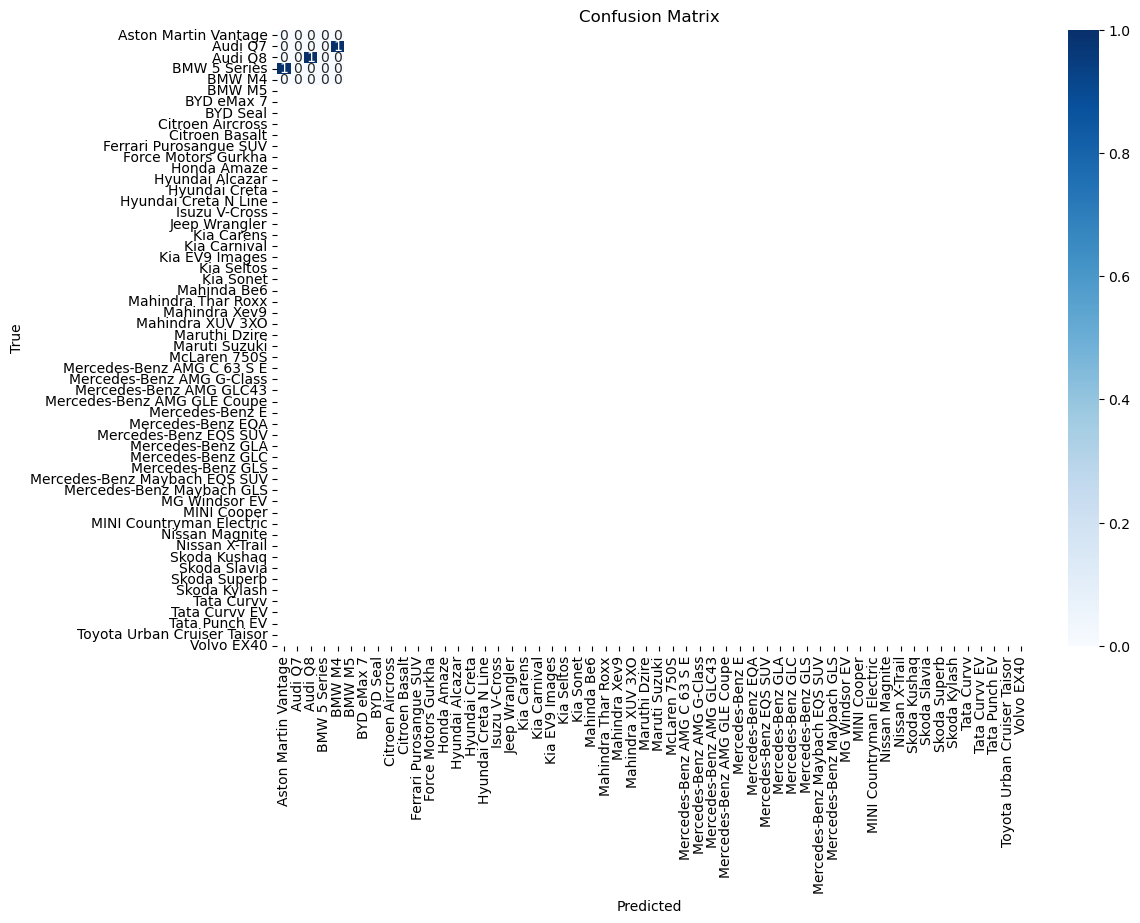

Error: Number of classes, 5, does not match size of target_names, 56. Try specifying the labels parameter


In [33]:
import os
from ultralytics import YOLO
from torch import nn
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def classify_image(model, class_names, image_path):
    """
    Classify an image using a YOLOv8 model.

    Parameters:
        model (YOLO): Loaded YOLOv8 model.
        class_names (list): List of class names corresponding to the model.
        image_path (str): Path to the image to classify.

    Returns:
        tuple: Predicted class index and confidence score.
    """
    # Check if the image path exists
    if not os.path.exists(image_path):
        raise ValueError(f"Invalid image file: {image_path}")

    # Perform inference
    results = model.predict(source=image_path, device='cpu')

    # Extract predictions
    if len(results) == 0 or not hasattr(results[0], 'probs'):
        raise ValueError("No valid predictions made by the model.")

    prediction = results[0]
    predicted_class_index = prediction.probs.top1  # Index of highest probability
    confidence = prediction.probs.top1conf  # Confidence score

    return predicted_class_index, confidence

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot the confusion matrix.

    Parameters:
        y_true (list): True class indices.
        y_pred (list): Predicted class indices.
        class_names (list): List of class names.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

if __name__ == "__main__":
    # Define paths
    model_path = "yolov8n_car_model_complete.pt"  # Correctly saved YOLO model path
    image_paths = [
        r"C:\\Users\\ENL-LPT022\\Downloads\\TC.jpeg",
        r"C:\\Users\\ENL-LPT022\\Downloads\\NXT.jpeg",
        r"C:\\Users\\ENL-LPT022\\Downloads\\BMW.jpeg"
    ]  # Replace with your test image paths
    true_labels = [7, 15, 20]  # Replace with the true class indices for the test images

    # Class names
    class_names = [
        "Aston Martin Vantage", "Audi Q7", "Audi Q8", "BMW 5 Series", "BMW M4", "BMW M5",
        "BYD eMax 7", "BYD Seal", "Citroen Aircross", "Citroen Basalt", "Ferrari Purosangue SUV",
        "Force Motors Gurkha", "Honda Amaze", "Hyundai Alcazar", "Hyundai Creta", "Hyundai Creta N Line",
        "Isuzu V-Cross", "Jeep Wrangler", "Kia Carens", "Kia Carnival", "Kia EV9 Images", "Kia Seltos",
        "Kia Sonet", "Mahinda Be6", "Mahindra Thar Roxx", "Mahindra Xev9", "Mahindra XUV 3XO", "Maruthi Dzire",
        "Maruti Suzuki", "McLaren 750S", "Mercedes-Benz AMG C 63 S E", "Mercedes-Benz AMG G-Class",
        "Mercedes-Benz AMG GLC43", "Mercedes-Benz AMG GLE Coupe", "Mercedes-Benz E", "Mercedes-Benz EQA",
        "Mercedes-Benz EQS SUV", "Mercedes-Benz GLA", "Mercedes-Benz GLC", "Mercedes-Benz GLS",
        "Mercedes-Benz Maybach EQS SUV", "Mercedes-Benz Maybach GLS", "MG Windsor EV", "MINI Cooper",
        "MINI Countryman Electric", "Nissan Magnite", "Nissan X-Trail", "Skoda Kushaq", "Skoda Slavia",
        "Skoda Superb", "Skoda Kylash", "Tata Curvv", "Tata Curvv EV", "Tata Punch EV", "Toyota Urban Cruiser Taisor",
        "Volvo EX40"
    ]

    # Ensure the model is saved correctly
    try:
        # Load YOLO model and update classification head
        model = YOLO("yolo11n-cls.pt")
        num_classes = 56
        num_features = model.model.model[-1].linear.in_features
        model.model.model[-1].linear = nn.Linear(num_features, num_classes)
        model.model.load_state_dict(torch.load("yolov11n_car_model.pt"))
        model.save(model_path)  # Save the model properly
        print("Model saved correctly.")
    except Exception as e:
        print(f"Error saving model: {e}")

    # Run classification
    y_true = []
    y_pred = []

    try:
        for image_path, true_label in zip(image_paths, true_labels):
            predicted_class_index, confidence = classify_image(model, class_names, image_path)
            y_true.append(true_label)
            y_pred.append(predicted_class_index)
            print(f"Image: {image_path}, Predicted: {class_names[predicted_class_index]} (Confidence: {confidence:.2f})")

        # Plot confusion matrix
        plot_confusion_matrix(y_true, y_pred, class_names)

        # Print classification report
        print(classification_report(y_true, y_pred, target_names=class_names))

    except Exception as e:
        print(f"Error: {e}")
